In [53]:
import cv2
import os
import os.path as osp
root_dir="./test/"
img_path=osp.join(root_dir, "images")
label_path=osp.join(root_dir, "labels")

In [160]:
#box 좌표 load
def read_boxes_from_file(file_path):
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespaces
            values = line.split(' ')  # Split line by space delimiter
            class_index = int(values[0])
            x1, y1, x2, y2 = map(float, values[1:])
            idx, box = class_index, (x1, y1, x2, y2)
            #boxes.append((idx,box,file_path))
    return box

#boxes=read_boxes_from_file("./test/labels/fortest.txt")
#print(boxes)

In [54]:
#IOU 계산식
def IOU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [89]:
results=[]
for i in range(8):
    b1=box_list[i][0][1]
    b2=infer_list[i][0][1]
    path=box_list[i][0][2].split("\\")
    path=path[1]
    img_path=path[:-3]
    #print(path)
    result=IOU(b1, b2)
    results.append((img_path,result))

file_path = './iou_sample.txt'

with open(file_path, 'w') as file:
    for item in results:
        line = f"{item[0]} {item[1]}\n"
        file.write(line)

    

In [248]:
#라벨링 텍스트 경로 및 이미지 경로 
from glob import glob

root_img='./test/images/'
root_txt='./test/labels/'
root_detected='./test_detected/labels/'

img_list=sorted(glob(root_img+'*.jpg'))
gt_list=sorted(glob(root_txt+'*.txt'))
detect_list=sorted(glob(root_detected+'*.txt'))

In [227]:
#이미지 사이즈가 고려된 절대 좌표로 변환 (x_center, y_center, w,h) -> (x_min, y_min, x_max, y_max)
def get_ab_point(box, size=640):
    x_cen = int(box[0]*size)
    y_cen = int(box[1]*size)
    w = int(box[2]*size)
    h = int(box[3]*size)

    x_min = int(x_cen - (w / 2)) 
    y_min = int(y_cen - (h / 2)) 
    x_max = int(x_cen + (w / 2)) 
    y_max = int(y_cen + (h / 2)) 

    return x_min, y_min, x_max, y_max

In [250]:
#이미지에 ground truth box 및 detected box 표시
def make_metric_pic(b1, b2, img_path, text):

    #print(box1,box2)
    img=cv2.imread(img_path)
    #print(img.shape)
    img_new=cv2.rectangle(img, (b1[0], b1[1]), (b1[2], b1[3]), (0, 0, 255), 5)
    img_new=cv2.rectangle(img_new, (b2[0], b2[1]), (b2[2], b2[3]), (0, 255, 0), 5)

    text = text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    thickness = 2
    text_color = (0, 0, 255)  

    text_width, text_height = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_x = (b1[0] + b1[2]) // 2 - text_width // 2
    text_y = b1[1] - 10  
    img_new=cv2.putText(img_new, text, (text_x, text_y), font, font_scale, text_color, thickness)

    return img_new

(2, 520, 272, 636) (4, 522, 300, 640)


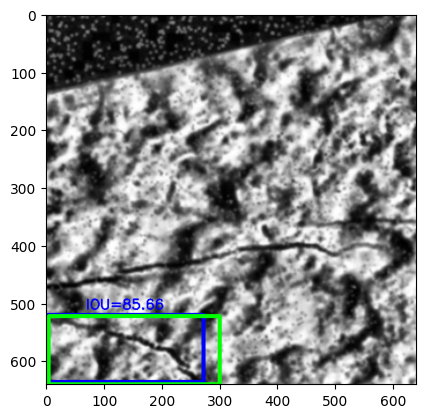

(610, 2, 640, 42) (606, 6, 640, 56)


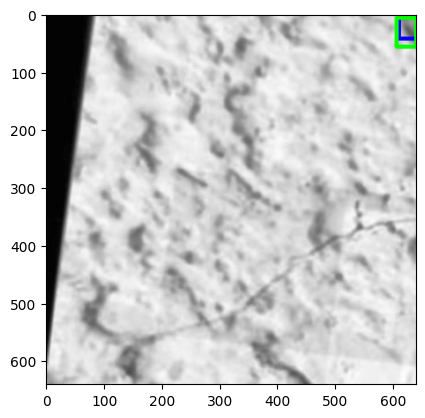

(382, 318, 576, 640) (387, 344, 562, 639)


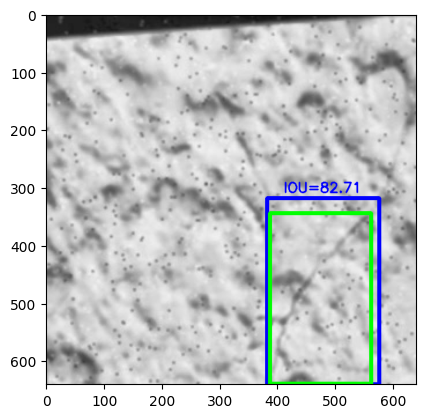

(266, 459, 639, 633) (282, 434, 636, 625)


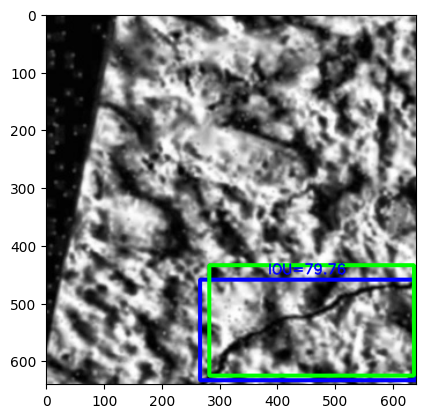

(2, 276, 322, 416) (5, 277, 341, 416)


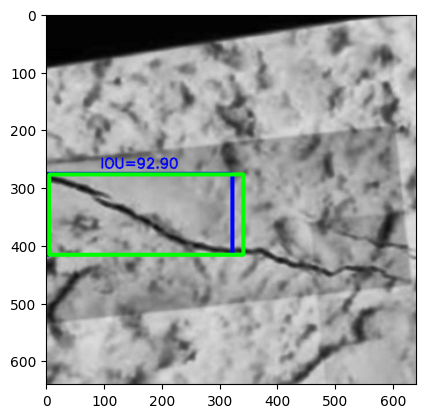

(305, 409, 636, 639) (313, 430, 639, 640)


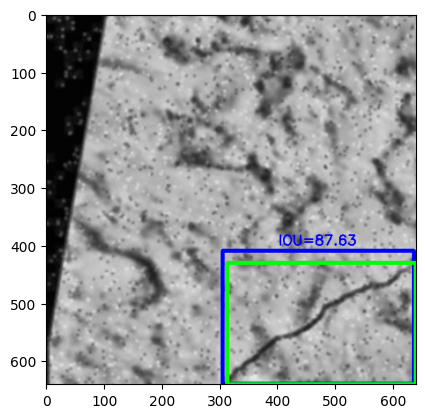

(0, 354, 313, 634) (3, 363, 309, 633)


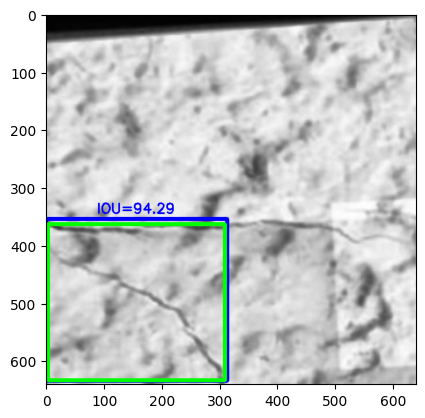

(401, 1, 428, 79) (409, 7, 429, 87)


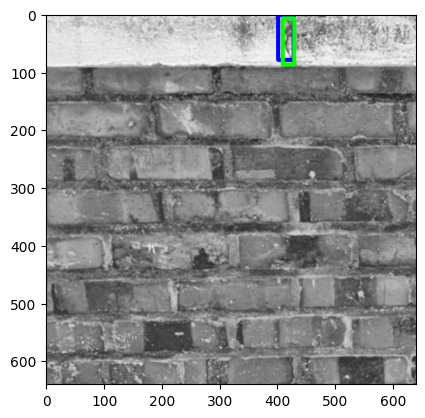

In [251]:
for i in range(len(detect_list)):
    b1=read_boxes_from_file(gt_list[i])
    b2=read_boxes_from_file(detect_list[i])
    
    b1=get_ab_point(b1)
    b2=get_ab_point(b2)
    print(b1, b2)
    iou=IOU(b1, b2)
    #print(iou)
    iou=format(iou*100, '.2f')
    img=make_metric_pic(b1,b2,img_list[i], text="IOU="+str((iou)))
    cv2.imwrite(f"./iou_metric/img{i}.jpg", img)
    plt.imshow(img)
    plt.show()